# Zwift

In [45]:
from IPython.display import display, clear_output, Markdown, HTML
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from sklearn.linear_model import LinearRegression
import sys

register_matplotlib_converters()

#ROOT = r'G:\My Drive\Personal\Others\Zwift'
ROOT = '.'

## Rides

In [15]:
rides = pd.read_excel(os.path.join(ROOT, 'rides.xlsx'), parse_dates=['dtime'])
rides = rides.sort_values('dtime')
rides['totalminutes'] = rides['minutes'].cumsum()
rides['time'] = pd.to_timedelta(rides['time'])
rides['seconds'] = rides['time'] / np.timedelta64(1, 's')
rides['avg speed'] = rides['distance'] / (rides['minutes'] / 60)
rides['avg watt/kg'] = rides['avg_watt'] / rides['weight']
#display(rides[['dtime', 'title', 'type', 'distance', 'elevation', 'calories']])
rides = rides.iloc[1:]
display(rides.iloc[-5:,])

,dtime,title,type,distance,totaldistance,elevation,totalelevation,calories,totalcalories,xp,...,minutes,avg_watt,normalized_power,avg_temp,avg_hr,avg_rpm,totalminutes,seconds,avg speed,avg watt/kg
28,2020-06-20 07:34:00,M150 (Failed Volcano Loop 10),correction,52.90,482.0,0.0,4756,0,7634,1493,...,130.316667,100.0,101.0,31.0,123.0,72.0,1547.966667,7819.0,24.356056,1.204819
29,2020-06-22 07:34:00,M9075 (Figure 8 Reverse),interval,35.56,517.0,340.0,5096,534,8168,1676,...,93.916667,112.0,114.0,31.8,126.0,65.0,1641.883333,5635.0,22.718012,1.349398
30,2020-06-24 07:10:00,M9075 (Royal Pump Room 8),interval,32.00,549.0,546.0,5642,553,8721,1680,...,100.250000,112.0,114.0,31.0,124.0,63.0,1742.133333,6015.0,19.152120,1.351025
31,2020-06-26 05:40:00,M9075 (Figure 8),interval,37.94,587.0,302.0,5944,550,9271,1726,...,94.566667,115.0,118.0,30.0,124.0,65.0,1836.700000,5674.0,24.071907,1.382212
32,2020-06-27 06:39:00,M150 (Volcano Loop 10),interval,54.95,642.0,273.0,6217,721,9992,2396,...,129.916667,111.0,118.0,32.0,125.0,62.0,1966.616667,7795.0,25.377806,1.337349


## Levelling

In [16]:
levels = pd.read_excel('levels.xlsx')
myxp = rides['totalxp'].max()

cur_level_row = levels[ levels['xp'] <= myxp ].iloc[-1]
my_level = cur_level_row['level']
next_level_row = levels[ levels['xp'] > myxp ].iloc[0]

print(f'You are in level {my_level}')
print(f'Next level needs {next_level_row["xp"] - myxp } xps ({next_level_row["xp"]})')

You are in level 13
Next level needs 2053 xps (33000)


## Best Wheels and Frames

In [17]:
def rank_gear(gear, level=None, look_forward_level=2):
    if level is None:
        level = my_level
        
    gears = pd.read_excel(f'{gear}.xlsx')
    gears = gears[['owned', 'name', 'type', 'level', 'price', 'flat time', 'climb time']]
    gears = gears.set_index('name')
    gears['owned'] = gears['owned'].replace(1, 'Yes').fillna('')
    gears['total time'] = gears['flat time'] + gears['climb time']
    best_time = gears['total time'].min()
    best_climb = gears['climb time'].min()
    best_flat = gears['flat time'].min()

    gears['extra climb'] = gears['climb time'] - best_climb
    gears['extra flat'] = gears['flat time'] - best_flat
    gears['total extra'] = gears['extra climb'] + gears['extra flat']

    gears = gears.sort_values('total extra')
    gears = gears[['owned', 'type', 'level', 'price', 'extra climb', 
                   'extra flat', 'total extra']]

    available_gears = gears[(gears['level'].notnull()) & 
                            (gears['level'] <= level+look_forward_level)]
    my_gears = gears[ gears['owned'] != '' ]
    my_best_gear = my_gears.sort_values('total extra').iloc[0]
    
    available_gears = available_gears[ (available_gears['total extra'] <= 
                                        my_best_gear['total extra']) |
                                       (available_gears['owned'] != '')]
    
    display(Markdown(f'### Best/better {gear} to use now or in next {look_forward_level} levels:'))
    display(available_gears)

    #display(Markdown(f'### Absolute best {gear}:'))
    #display(gears)
    
rank_gear('wheels', None, 5)
rank_gear('frames', None, 5)

### Best/better wheels to use now or in next 5 levels:

,owned,type,level,price,extra climb,extra flat,total extra
name,,,,,,,
Zipp 808,,-,13,177600,16,10,26
Zipp 404,,-,15,149200,8,20,28
ENVE SES 3.4,Yes,-,4,191700,5,26,31
32mm Carbon,Yes,-,0,0,14,53,67


### Best/better frames to use now or in next 5 levels:

,owned,type,level,price,extra climb,extra flat,total extra
name,,,,,,,
Cervelo P5,,TT,15,710000,72,7,79
Specialized Shiv Disc,,TT,18,994000,80,3,83
Specialized Shiv S-Works,,TT,10,852000,70,14,84
Scott Plasma,,TT,17,852000,71,14,85
Specialized Shiv,,TT,10,710000,79,15,94
Spec. Tarmac Pro,Yes,standard,11,408300,0,109,109
Zwift TT,Yes,TT,0,0,96,32,128
Zwift Carbon,Yes,standard,0,0,38,111,149


## Progress

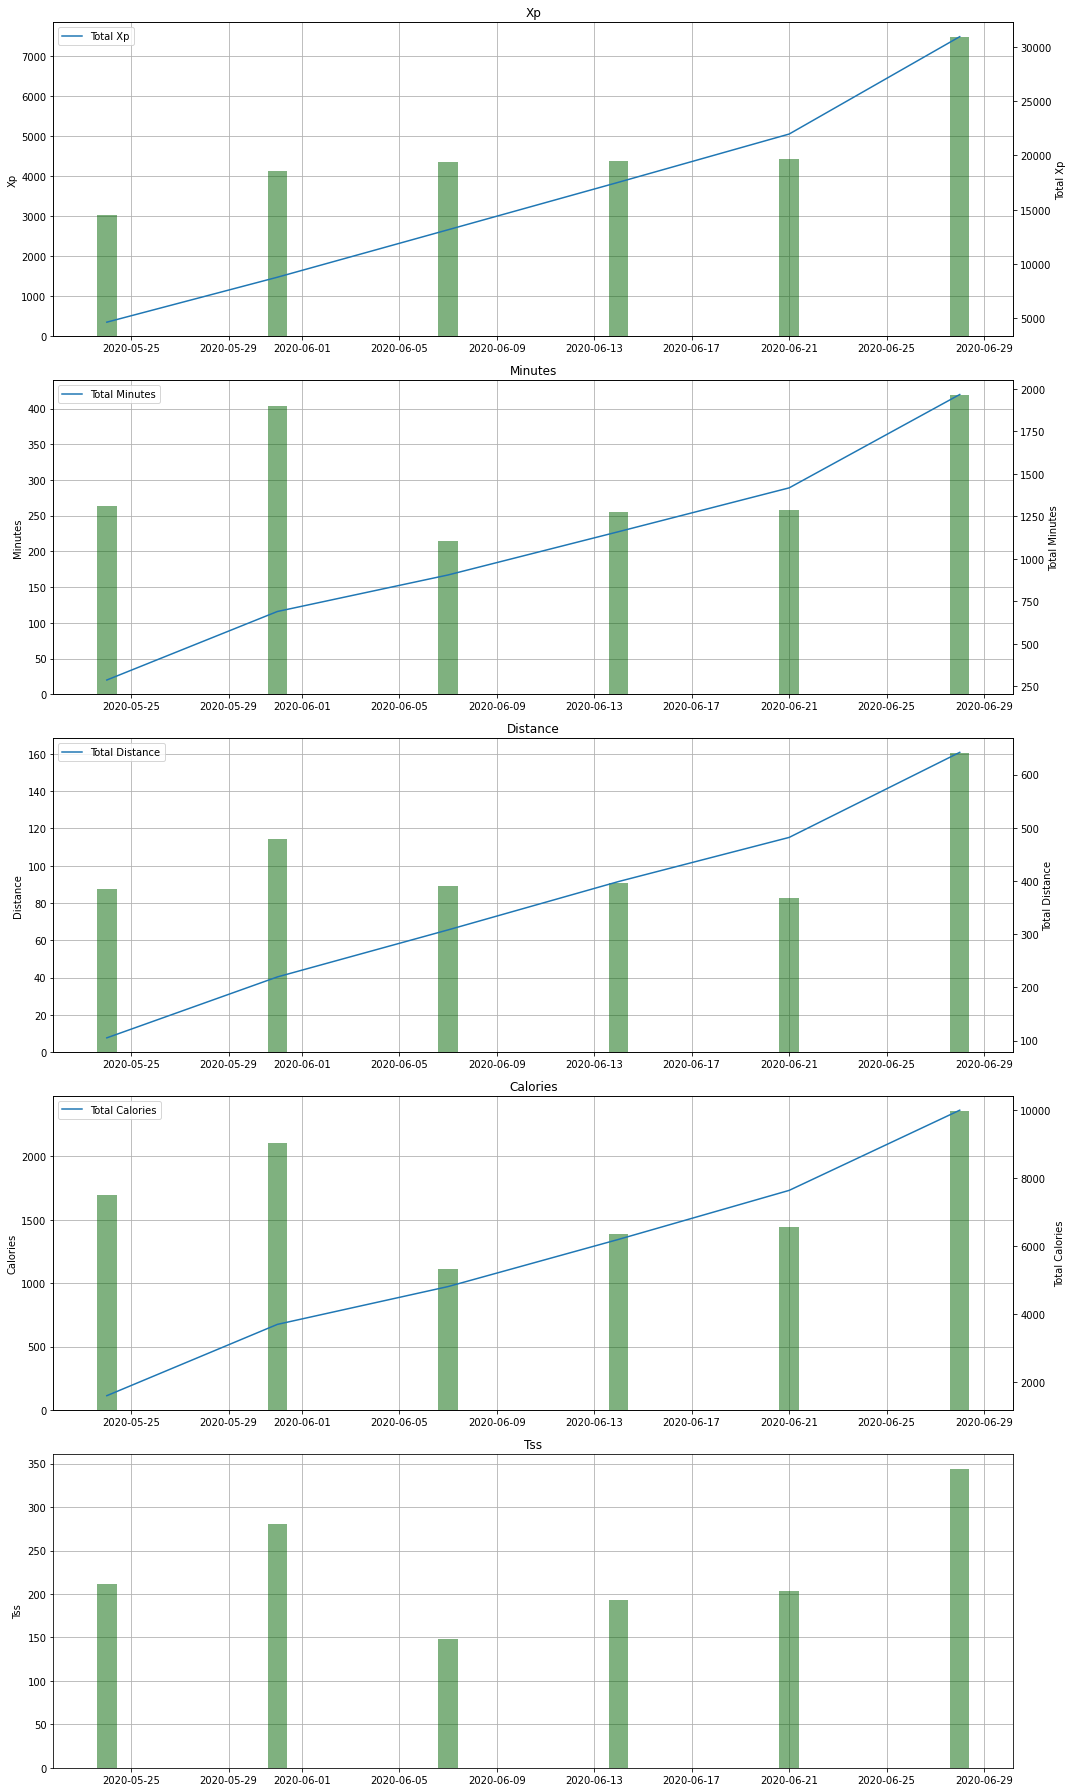

In [18]:
def plot_progress(interval):
    def _apply(subset):
        if len(subset)==0:
            return pd.Series({'xp': np.NaN,
                              'totalxp': np.NaN,
                              'calories': np.NaN,
                              'totalcalories': np.NaN,
                              'minutes': np.NaN,
                              'totalminutes': np.NaN,
                              'distance': np.NaN,
                              'totaldistance': np.NaN,
                              'tss': np.NaN})
        total_minutes = subset['minutes'].sum()
        avg_watt = (subset['avg_watt'] * subset['minutes']).sum() / total_minutes
        avg_ftp = subset['ftp'].mean()
        tss = (total_minutes / 60) * (avg_watt ** 2) / (avg_ftp ** 2) * 100
        #print(f'{subset.name} avg_watt:{avg_watt:.1f} total_minutes:{total_minutes:.0f} avg_ftp:{avg_ftp:.0f} tss:{tss:.1f}')
        return pd.Series({'xp': subset['xp'].sum(),
                          'totalxp': subset['totalxp'].iloc[-1],
                          'calories': subset['calories'].sum(),
                          'totalcalories': subset['totalcalories'].iloc[-1],
                          'minutes': subset['minutes'].sum(),
                          'totalminutes': subset['totalminutes'].iloc[-1],
                          'distance': subset['distance'].sum(),
                          'totaldistance': subset['totaldistance'].iloc[-1],
                          'tss': tss})
    
    #rides['ftp'] = 150
    df = rides[ rides['type'] != 'correction' ] \
                .set_index('dtime') \
                .groupby(pd.Grouper(freq=interval)) \
                .apply(_apply)
    
    metrics = ['xp', 'minutes', 'distance', 'calories', 'tss']
    fig, axis = plt.subplots(len(metrics), 1, figsize=(15,5*len(metrics)))
    
    for i_m, metric in enumerate(metrics):
        ax = axis[i_m]
        ax.set_title(metric.title())
        ax.bar(df.index, df[metric], color='darkgreen', alpha=0.5, zorder=5)
        ax.set_ylabel(f'{metric.title()}')
        ax.grid()
        #ax.legend()
        if f'total{metric}' in df.columns:
            ax_b = ax.twinx()
            ax_b.plot(df.index, df[f'total{metric}'], label=f'Total {metric.title()}', zorder=10)
            ax_b.set_ylabel(f'Total {metric.title()}')
        plt.legend()
        
    
    fig.tight_layout()
    
plot_progress('W-SUN')
#plot_progress('1D')

## MAF

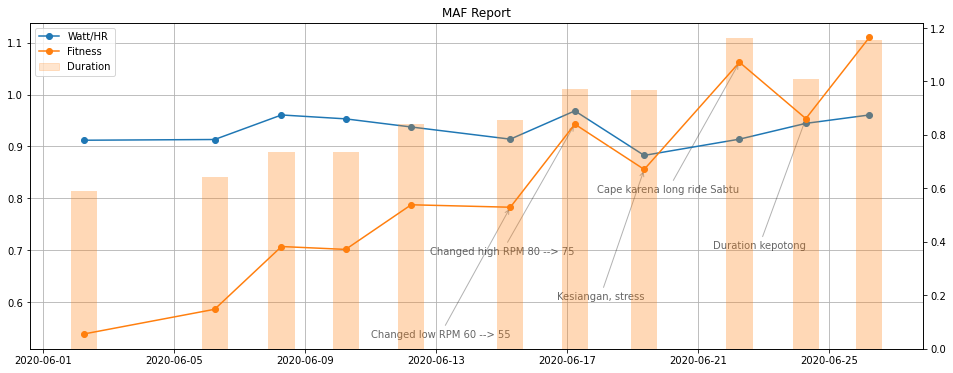

,dtime,type,title,duration,avg_power,normalized_power,avg_rpm,avg_hr,max_hr,weight,temperature,calories,garmin_weight,note,watt/hr,fitness
1,2020-06-02 06:13:00,maf,M6065,0.591111,114,114,70,125,133,82.8,31.3,220,NaN,NaN,0.912000,0.539093
2,2020-06-06 06:00:00,maf,M6070,0.642222,116,117,68,127,134,84.1,32.0,267,83.3,NaN,0.913386,0.586597
3,2020-06-08 07:00:00,maf,M7070,0.736389,122,123,67,127,132,83.5,31.6,313,84.1,NaN,0.960630,0.707397
4,2020-06-10 06:00:00,maf,M7570,0.736389,122,124,67,128,136,82.6,31.3,316,83.3,NaN,0.953125,0.701871
5,2020-06-12 06:00:00,maf,M7070,0.840278,120,120,65,128,132,83.7,31.0,362,83.7,NaN,0.937500,0.787760
6,2020-06-15 06:39:00,maf,M8070,0.856667,117,118,64,128,132,82.8,32.0,362,82.8,Changed low RPM 60 --> 55,0.914062,0.783047
7,2020-06-17 05:54:00,maf,M8070,0.973611,123,124,63,127,133,83.3,31.0,431,83.3,Changed high RPM 80 --> 75,0.968504,0.942946
8,2020-06-19 08:44:00,maf,M8070,0.969444,113,116,60,128,135,82.5,32.0,396,82.7,"Kesiangan, stress",0.882812,0.855838
9,2020-06-22 06:32:00,maf,M9075,1.161944,117,118,61,128,136,83.0,32.0,490,83.0,Cape karena long ride Sabtu,0.914062,1.062090
10,2020-06-24 07:10:00,maf,M9075,1.009722,119,120,63,126,135,82.9,31.0,434,82.9,Duration kepotong,0.944444,0.953627


In [19]:
def maf_report():
    maf = pd.read_excel('maf-test.xlsx', parse_dates=['dtime'])
    maf = maf[ maf['type']=='maf' ]
    maf['duration'] = pd.to_timedelta(maf['duration']).dt.seconds / 3600
    maf['watt/hr'] = maf['avg_power'] / maf['avg_hr']
    maf['fitness'] = maf['watt/hr'] * maf['duration']

    fig, ax = plt.subplots(nrows=1, figsize=(16,6))
    #ax = axs[0]
    handles = ax.plot(maf['dtime'], maf['watt/hr'], 'o-', zorder=10, 
                      label='Watt/HR')
    
    handles.extend( ax.plot(maf['dtime'], maf['fitness'], 'o-', 
                            zorder=15,  label='Fitness') )
    
    for i_row in range(len(maf)):
        row = maf.iloc[i_row,:]
        
        note = str(row['note']).strip() if not pd.isnull(row['note']) else ''
        if note:
            ax.annotate(note, xy=(row['dtime'], row['fitness']), xycoords='data',
                        xytext=(row['dtime'], row['fitness']-0.25),
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="arc3",
                                        alpha=0.3),
                        alpha=0.6, ha='right')
    
    ax.grid()

    ax2 = ax.twinx()
    ax2.bar(maf['dtime'], maf['duration'], 
            color='C1', alpha=0.3, zorder=1, label='Duration' )
    handles.append( plt.Rectangle((0,0),1,1, color='C1', alpha=0.2) )

    ax.legend(handles, ['Watt/HR', 'Fitness', 'Duration'], loc=2)
    ax.set_title('MAF Report')

    plt.show()
    return maf
    
maf_report()

## Duration Predictor

In [20]:
df = rides[ rides['type'] != 'correction' ]
df = df[ df['dtime'] > '2020-06-01' ]
print(f'Using {len(df)} rides')
X = df[['distance', 'elevation', 'avg watt/kg']]
y = df['minutes']
reg = LinearRegression().fit(X, y)
pred = reg.predict(X)
mse = np.mean( (pred - y)**2 )
me = np.mean( mse ** 0.5 )
me_pct = np.mean( np.abs(pred-y) / y )
print(f'Mean error: {me:.1f} minutes')
print(f'Mean error: {me_pct:.1%}')

Using 14 rides
Mean error: 4.2 minutes
Mean error: 3.9%


## Running Planner

In [21]:
routes = pd.read_excel(os.path.join(ROOT, 'routes.xlsx'))
for col in ['done', 'badge', 'restriction', 'lead-in', 'elevation']:
    routes[col] = routes[col].fillna(0)

routes['restriction'] = routes['restriction'].fillna('').astype(str)

In [22]:
def running_best_route(pace, max_duration, min_duration=None, kind=None, done=None):
    assert kind is None or kind in ['run', 'interval', 'workout']
    max_minutes = pd.Timedelta(max_duration).total_seconds() / 60
    df = routes.copy()
    
    # In "run" mode, Zwift awards 10 xp per 0.25 km
    XP_PER_250M = 10
    
    # In "interval", reward is 12 XP per minute. But there will be other
    # blocks such as warmups and free rides so usually we won't get the full XPs
    XP_PER_MIN_ITV = 12 * 0.95
    
    # In "workout" blocks, reward is 10 XP per minute for workout blocks and
    # 5-6 XP per minute for warmup/rampup/cooldown/rampdown blocks.
    XP_PER_MIN_WRK = 10 * 0.8 + 5.5 * 0.2
    
    #df = df[ ~df['restriction'].str.contains('Run') ]
    df = df[ ~df['restriction'].str.contains('Event') ]
    df = df.set_index(['world', 'route'])
    df['total distance'] = df['distance'] + df['lead-in']
    df['pace'] = pace
    df['speed'] = round(60/pace, 1)
    
    # Set for better display
    df[['done', 'elevation', 'badge']] = df[['done', 'elevation', 'badge']].astype(int)
    
    # Clear badge if route is done
    df.loc[df['done'] != 0, 'badge'] = 0
    
    # Total time is calculated from pace
    df['pred minutes'] = df['total distance'] * pace
    
    # Predict the XPs received for ride and interval activities, assuming that we finish
    # the full route.
    df['pred xp (run)'] = (np.floor(df['total distance'] * 4) * XP_PER_250M + df['badge']).astype(int)
    df['pred xp (interval)'] = (np.floor(df['pred minutes']) * XP_PER_MIN_ITV + df['badge']).astype(int)
    df['pred xp (workout)'] = (np.floor(df['pred minutes']) * XP_PER_MIN_WRK + df['badge']).astype(int)
    
    # Set which is the best activity (run or interval), unless it's forced
    if not kind:
        df['best activity'] = df[['pred xp (run)', 'pred xp (interval)', 'pred xp (workout)']].idxmax(axis=1)
        df['best activity'] = df['best activity'].str.extract(r'\((.*)\)')

        # Set the best XP received if the best activity is selected
        df['best pred xp'] = df[['pred xp (run)', 'pred xp (interval)', 'pred xp (workout)']].max(axis=1)
    else:
        df['best activity'] = kind
        df['best pred xp'] = df[f'pred xp ({kind})']
        
    df['best pred xp/minutes'] = (df['best pred xp'] / df['pred minutes']).round(1)
    
    # Filter only routes less than the specified duration
    df = df[ df['pred minutes'] <= max_minutes]
    
    # Filter only routes with at least the specified duration
    if min_duration:
        min_minutes = pd.Timedelta(min_duration).total_seconds() / 60
        df = df[ df['pred minutes'] > min_minutes]
        
    # Display result
    columns = ['done', 'total distance', 'distance', 'lead-in', 'elevation', 'badge', 
               'best activity', 'best pred xp', 'pace', 'speed', 'pred minutes', 'best pred xp/minutes']
    df = df[columns]
    #df = df.sort_values(['best pred xp/minutes'], ascending=False)
    df = df.sort_values(['best pred xp'], ascending=False)
    if done is not None:
        df = df[ df['done']==done ]
        
    return df


running_best_route(9.5, '0:60:00', min_duration='0:20:00', kind='workout').head(15)

,,done,total distance,distance,lead-in,elevation,badge,best activity,best pred xp,pace,speed,pred minutes,best pred xp/minutes
world,route,,,,,,,,,,,,
Watopia,5K Loop,0,5.3,5.0,0.3,0,200,workout,655,9.5,6.3,50.35,13.0
New York,Park to Peak,0,4.7,4.6,0.1,0,180,workout,580,9.5,6.3,44.65,13.0
Yorkshire,Queen's Highway,0,5.8,3.0,2.8,121,60,workout,560,9.5,6.3,55.10,10.2
Watopia,Run Path Reverse,0,5.3,5.0,0.3,0,0,workout,455,9.5,6.3,50.35,9.0
Yorkshire,Duchy Estate,1,4.7,3.0,1.7,40,0,workout,400,9.5,6.3,44.65,9.0
New York,Shuman Trail Loop,0,2.8,2.5,0.3,0,0,workout,236,9.5,6.3,26.60,8.9


## Workout Displayer

In [51]:
def parse_workout_file(path, ftp):
    from xml.dom.minidom import parse, parseString
    
    def _getText(childNodes):
        rc = []
        for node in childNodes:
            if node.nodeType == node.TEXT_NODE:
                rc.append(node.data)
        return ''.join(rc)

    def _to_time(sec):
        sec = int(float(sec))
        if sec < 3600:
            return f'{sec//60:02d}:{sec%60:02d}'
        else:
            return f'{sec//3600:}:{(sec%3600)//60:02d}:{sec%60:02d}'
    
    doc = parse(path)
    print(f'Title      : {_getText(doc.getElementsByTagName("name")[0].childNodes)}')
    print(f'Author     : {_getText(doc.getElementsByTagName("author")[0].childNodes)}')
    print(f'Description: {_getText(doc.getElementsByTagName("description")[0].childNodes)}')
    print('Workouts:')
    
    workout = doc.getElementsByTagName('workout')[0]
    time = 0
    rows = []
    for node in workout.childNodes:
        if node.nodeType == node.TEXT_NODE:
            pass
        elif node.tagName.lower() == "freeride":
            duration = int(node.attributes['Duration'].value)
            text = ''
            for child in node.childNodes:
                if child.nodeType != node.TEXT_NODE and child.tagName.lower()=='textevent':
                    when = child.attributes['timeoffset'].value
                    msg = child.attributes['message'].value
                    text += f"[{_to_time(when)}] {msg}\n"
            rows.append( {"time": time, 
                          "type": 'freeride', 
                          "duration": duration,
                          "repeat": '', 
                          "on watt": '', 
                          "on duration": '',
                          "on rpm": '',
                          "off_watt": '', 
                          "off duration": '',
                          "off rpm": '',
                          "text": text} )            
            
            time += duration
        elif node.tagName.lower() == "intervalst":
            repeat = int(node.attributes['Repeat'].value)
            on_duration = int(node.attributes['OnDuration'].value)
            off_duration = int(node.attributes['OffDuration'].value)
            on_power = float(node.attributes['OnPower'].value) * ftp
            off_power = float(node.attributes['OffPower'].value) * ftp
            if 'Cadence' in node.attributes:
                on_cadence = f"{node.attributes['Cadence'].value}"
                off_cadence = f"{node.attributes['CadenceResting'].value}"
            else:
                on_cadence = ''
                off_cadence = ''
            duration = repeat * (on_duration + off_duration)
            text = ''
            for child in node.childNodes:
                if child.nodeType != node.TEXT_NODE and child.tagName.lower()=='textevent':
                    when = child.attributes['timeoffset'].value
                    msg = child.attributes['message'].value
                    text += f"[{_to_time(when)}] {msg}\n"
                    if float(when)+20 > duration:
                        sys.stderr.write(f'Error: text event exceeds duration ([{_to_time(when)}] {msg})\n')
            rows.append( {"time": time, 
                          "type": 'interval', 
                          "duration": duration,
                          "repeat": repeat, 
                          "on watt": on_power, 
                          "on duration": on_duration,
                          "on rpm": on_cadence,
                          "off_watt": off_power, 
                          "off duration": off_duration,
                          "off rpm": off_cadence,
                          "text": text} )
            time += duration
            
    rows.append( {"time": time, 
                  "type": 'end', 
                  "duration": 0,
                  "repeat": '', 
                  "on watt": '', 
                  "on duration": '',
                  "on rpm": '',
                  "off_watt": '', 
                  "off duration": '',
                  "off rpm": '',
                  "text": ''} )            
            
    df = pd.DataFrame(rows)
    df['time'] = df['time'].apply(_to_time)
    df['duration'] = df['duration'].apply(_to_time)
    display( HTML( df.to_html().replace("\\n","<br>") ) )

    return
    
parse_workout_file('/home/bennylp/Desktop/tmp/zwift/M4570.zwo', ftp=160)

Title      : M4575
Author     : 2 Jelly Legs
Description: 45 minutes MAF workout, peaking at 75% power, with cadence variance
Workouts:


,time,type,duration,repeat,on watt,on duration,on rpm,off_watt,off duration,off rpm,text
0,00:00,freeride,00:31,,,,,,,,
1,00:31,interval,02:02,2,80,30,,80,31,,
2,02:33,interval,02:02,2,90,30,,90,31,,
3,04:35,interval,02:02,2,100,30,,100,31,,
4,06:37,interval,02:02,2,110,30,85,110,31,65,
5,08:39,interval,04:04,4,120,30,100,115.2,31,80,
6,12:43,freeride,02:01,,,,,,,,[00:09] Cool down now[01:40] Prepare to press lap
7,14:44,interval,06:02,2,120,90,75,120,91,55,[00:10] Press lap on watch[02:00] Have you pressed lap
8,20:46,interval,06:02,2,120,90,75,120,91,55,
9,26:48,interval,06:02,2,120,90,75,120,91,55,


## Most Profitable Routes

In [25]:
def best_route(avg_watt_per_kg, weight, max_duration, min_duration=None, kind=None, done=None):
    assert kind is None or kind in ['ride', 'interval', 'workout']
    max_minutes = pd.Timedelta(max_duration).total_seconds() / 60
    df = routes.copy()
    
    # In "ride" mode, Zwift awards 20 xp per km
    XP_PER_KM = 20
    
    # In "interval", reward is 12 XP per minute. But there will be other
    # blocks such as warmups and free rides so usually we won't get the full XPs
    XP_PER_MIN_ITV = 12 * 0.95
    
    # In "workout" blocks, reward is 10 XP per minute for workout blocks and
    # 5-6 XP per minute for warmup/rampup/cooldown/rampdown blocks.
    XP_PER_MIN_WRK = 10 * 0.8 + 5.5 * 0.2
    
    df = df[ ~df['restriction'].str.contains('Run') ]
    df = df[ ~df['restriction'].str.contains('Event') ]
    df = df.set_index(['world', 'route'])
    df['total distance'] = df['distance'] + df['lead-in']
    df['avg watt'] = avg_watt_per_kg * weight
    df['avg watt/kg'] = avg_watt_per_kg
    
    # Set for better display
    df[['done', 'elevation', 'badge']] = df[['done', 'elevation', 'badge']].astype(int)
    
    # Clear badge if route is done
    df.loc[df['done'] != 0, 'badge'] = 0
    
    # Predict ride duration using linear regressor
    df['pred minutes'] = reg.predict(df[['total distance', 'elevation', 'avg watt/kg']]).round(1)
    df['pred avg speed'] = (df['total distance'] / (df['pred minutes'] / 60.0)).round(1)
    
    # Predict the XPs received for ride and interval activities, assuming that we finish
    # the full route.
    df['pred xp (ride)'] = (np.floor(df['total distance']) * XP_PER_KM + df['badge']).astype(int)
    df['pred xp (interval)'] = (np.floor(df['pred minutes']) * XP_PER_MIN_ITV + df['badge']).astype(int)
    df['pred xp (workout)'] = (np.floor(df['pred minutes']) * XP_PER_MIN_WRK + df['badge']).astype(int)
    
    # Set which is the best activity (ride or interval), unless it's forced
    if not kind:
        df['best activity'] = df[['pred xp (ride)', 'pred xp (interval)', 'pred xp (workout)']].idxmax(axis=1)
        df['best activity'] = df['best activity'].str.extract(r'\((.*)\)')

        # Set the best XP received if the best activity is selected
        df['best pred xp'] = df[['pred xp (ride)', 'pred xp (interval)', 'pred xp (workout)']].max(axis=1)
    else:
        df['best activity'] = kind
        df['best pred xp'] = df[f'pred xp ({kind})']
        
    df['best pred xp/minutes'] = (df['best pred xp'] / df['pred minutes']).round(1)
    
    # Filter only routes less than the specified duration
    df = df[ df['pred minutes'] <= max_minutes]
    
    # Filter only routes with at least the specified duration
    if min_duration:
        min_minutes = pd.Timedelta(min_duration).total_seconds() / 60
        df = df[ df['pred minutes'] > min_minutes]
        
    # Display result
    columns = ['done', 'total distance', 'distance', 'lead-in', 'elevation', 'badge', 
               'best activity', 'best pred xp', 'avg watt', 'avg watt/kg', 'pred avg speed', 
               'pred minutes', 'best pred xp/minutes']
    df = df[columns]
    df['avg watt'] = df['avg watt'].astype(int)
    df['avg watt/kg'] = df['avg watt/kg'].round(2)
    #df = df.sort_values(['best pred xp/minutes'], ascending=False)
    df = df.sort_values(['best pred xp'], ascending=False)
    if done is not None:
        df = df[ df['done']==done ]
        
    return df

def best_route_by_watt(avg_watt, weight, duration, kind=None, done=None):
    duration = pd.Timedelta(duration)
    min_duration = duration - pd.Timedelta(minutes=5)
    max_duration = duration + pd.Timedelta(minutes=5)
    return best_route(avg_watt/weight, weight, max_duration, min_duration=min_duration, 
                      kind=kind, done=done)
    
def calc_avg_watt(ftp, tss, duration):
    # TSS = hour * avg_watt**2 / ftp**2 * 100
    # avg_watt = (tss / hour * ftp**2 / 100) ** 0.5
    hour = pd.Timedelta(duration).total_seconds() / 3600
    return (tss * (ftp**2) / hour / 100) ** 0.5
    
def calc_tss(ftp, avg_watt, duration):
    #np = avg_watt
    #IF = np / ftp
    #tss = (pd.Timedelta(duration).total_seconds()  * np * IF) / (ftp * 3600) * 100
    tss = pd.Timedelta(duration).total_seconds() / 3600 * (avg_watt ** 2) / (ftp ** 2) * 100
    return tss

def best_route_by_tss(ftp, weight, tss, duration, kind=None, done=None):
    duration = pd.Timedelta(duration)
    avg_watt = calc_avg_watt(ftp, tss, duration)
    return best_route(avg_watt/weight, weight, duration+pd.Timedelta(minutes=10), 
                      min_duration=duration-pd.Timedelta(minutes=10), 
                      kind=kind, done=done)

# Monday: Step-down interval
#best_route_by_tss(160, 83, 62, '0:50:00', kind='workout')

# Tuesday: Low-cadence interval
#best_route_by_tss(160, 83, 53, '0:50:00', kind='workout')

# Thursday: The long ride
#best_route_by_tss(160, 83, 42, '0:50:00', kind='interval')

# Rest day
#best_route(84/83, 83, '0:35:00')
#best_route_by_tss(160, 83, 16, '0:25:00')

# M4575
best_route(115/83, 83, '0:45:00').head(10)

# M9075
#best_route(115/83, 83, '1:30:00').head(10)

# M150
#best_route(115/83, 83, '2:05:00').head(10)

,,done,total distance,distance,lead-in,elevation,badge,best activity,best pred xp,avg watt,avg watt/kg,pred avg speed,pred minutes,best pred xp/minutes
world,route,,,,,,,,,,,,,
New York,Lady Liberty,0,12.7,12.3,0.4,197,240,interval,741,114,1.39,17.0,44.8,16.5
Watopia,Jungle Circuit,0,13.6,7.9,5.7,79,260,interval,716,114,1.39,20.3,40.2,17.8
New York,Astoria Line 8,0,11.9,11.5,0.4,141,230,interval,686,114,1.39,17.8,40.2,17.1
Yorkshire,Tour of Tewit Well,0,10.4,10.4,0.0,200,210,interval,666,114,1.39,15.4,40.5,16.4
Watopia,Volcano Flat,0,12.8,12.3,0.5,46,240,interval,650,114,1.39,20.9,36.8,17.7
New York,Park Perimeter Loop,0,10.2,9.8,0.4,126,190,interval,600,114,1.39,17.0,36.1,16.6
Watopia,Flat Route,0,10.8,10.3,0.5,54,200,interval,576,114,1.39,19.4,33.4,17.2
Richmond,Cobbled Climbs,0,9.5,9.2,0.3,126,180,interval,567,114,1.39,16.4,34.8,16.3
Watopia,Hilly Route,0,9.6,9.1,0.5,100,180,interval,556,114,1.39,17.1,33.6,16.5
